# Preliminary info:
- Data comes pre-split into train test, however the test set only contains one instance of each class
- There are 29 subdirectories in the train set, 3 of which are nonalpha 
- We'll also disregard J and Z since they require movement to sign
- Train set: 87,000 images which are 200x200 pixels
- Test set: 29 images same reso
- Need to think about having an 'other' class

In [75]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os

In [77]:
dir_path = "../data/asl_data/"
train_path = dir_path + "asl_alphabet_train/"
test_path = dir_path + "asl_alphabet_test/"

# map alphabet to numbers
categories = {  0: "A",
                1: "B",
                2: "C",
                3: "D",
                4: "E",
                5: "F",
                6: "G",
                7: "H",
                8: "I",
                9: "G",
                10: "K",
                11: "L",
                12: "M",
                13: "N",
                14: "O",
                15: "P",
                16: "Q",
                17: "R",
                18: "S",
                19: "T",
                20: "U",
                21: "V",
                22: "W",
                23: "X",
                24: "Y",
            }

def add_class_name_prefix(df, col_name):
    df[col_name]
    return df

# store all the file names in the dataset
filenames = []
# store the corresponding class for each file
target = []

for category in categories:
    files = os.listdir(train_path + categories[category])
    filenames += files
    target += [category] * len(files)

df = pd.DataFrame({"filename": filenames, "category": target})
df = add_class_name_prefix(df, "filename")

# shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [78]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  75000 non-null  object
 1   category  75000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


,filename,category
0,X19.jpg,23
1,G813.jpg,9
2,L2603.jpg,11
3,O2574.jpg,14
4,K1920.jpg,10


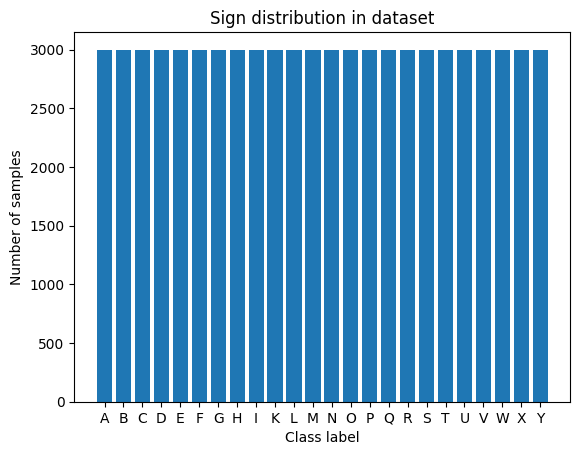

In [73]:
# plot class distribution
unique_labels, counts = np.unique(df['category'], return_counts=True)

plt.bar(list(categories.values()), counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Sign distribution in dataset')
plt.show()

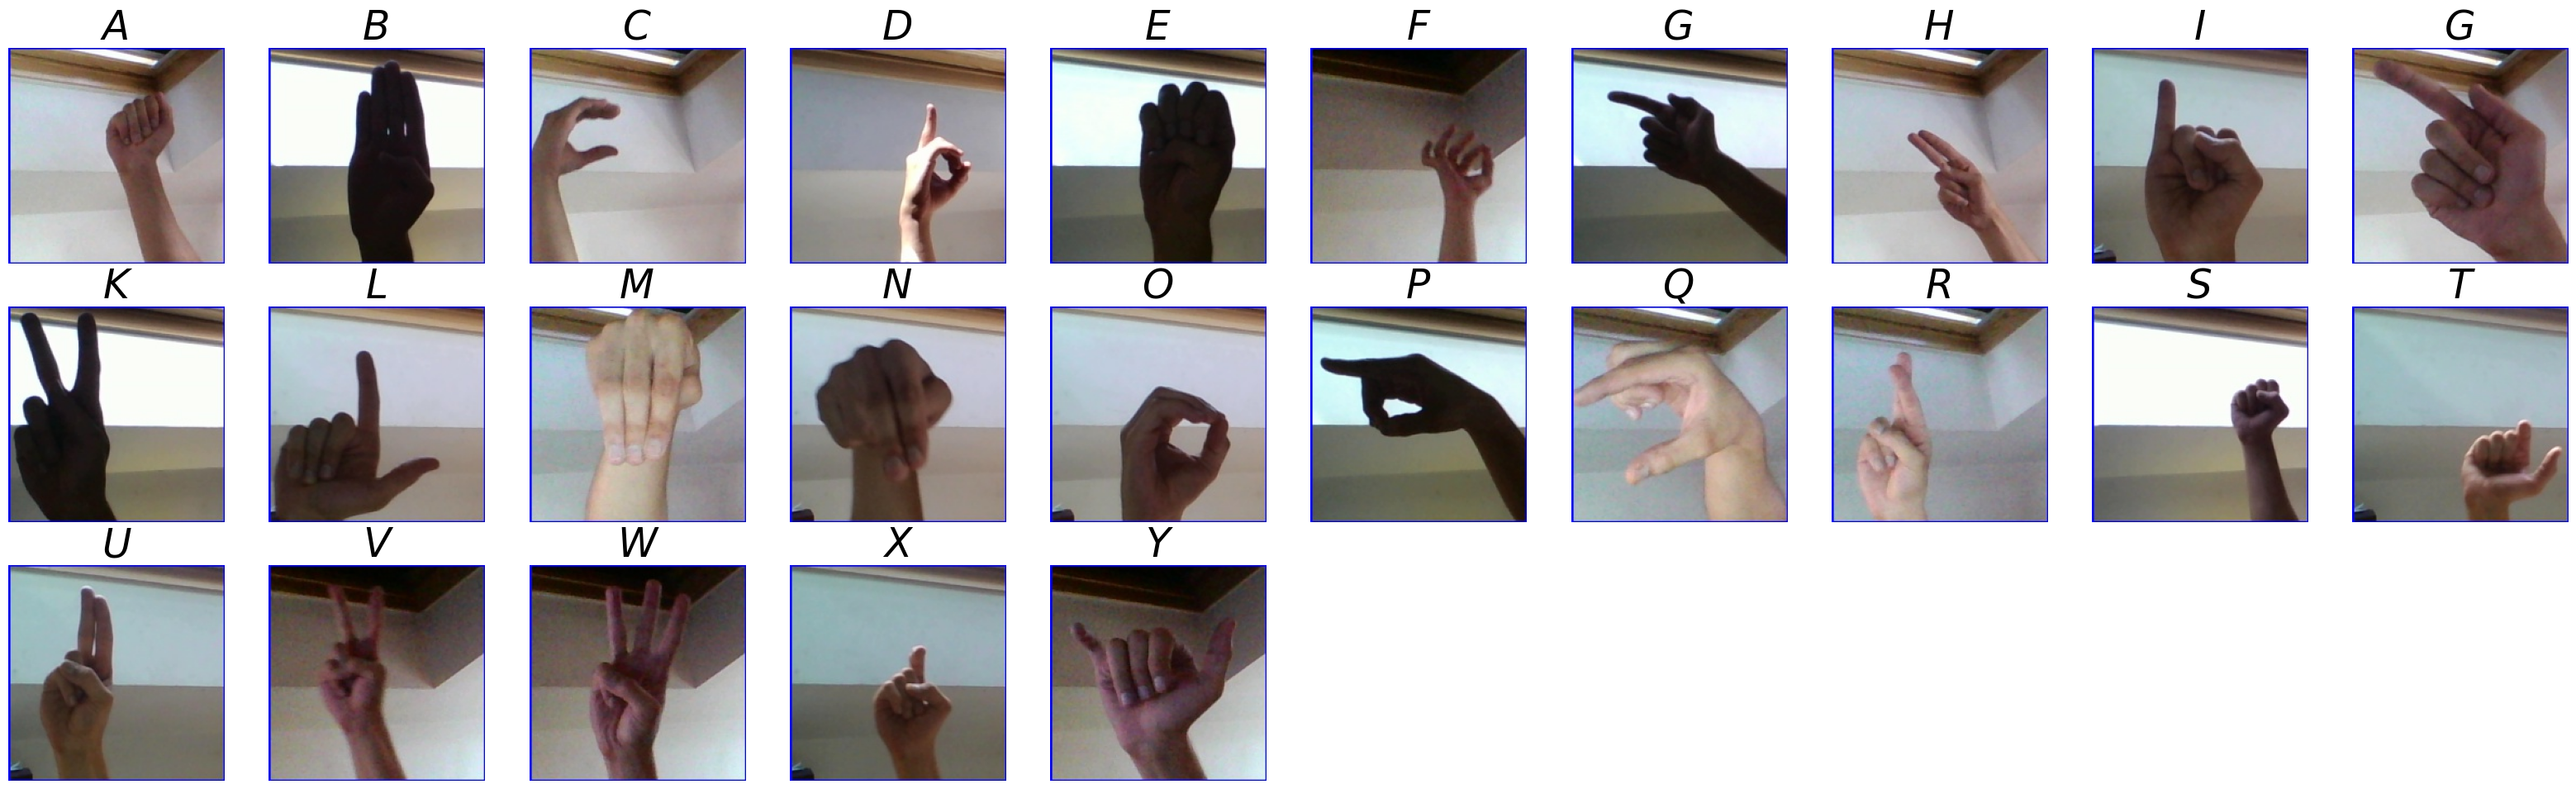

In [79]:
# plot a few example images

plt.figure(figsize=(40,40))

for i in range(25):
    img_names = df.loc[df["category"]==i]
    img_name = img_names.sample(ignore_index=True).filename[0]
    path = ""
    path = train_path + categories[i] + "/" + img_name
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[i],fontsize=35,fontstyle='italic')
    plt.axis("off")

# Attempting some low dim visualization

In [82]:
# i could not get cv2 to work in pipenv
import cv2

# image to numbers
def process_row(row):
    filename = row["filename"]
    label = row["label"]
    # load
    image = cv2.imread(train_path + "/" + categories[label] + "/" + filename)
    # convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # flatten 2d tensor to 1d array
    flat_image = gray_image.ravel()
    
    new_row = pd.DataFrame({'image_array': [flat_image], 'label': label})
    return new_row

df.apply(process_row, axis=1, result_type="expand")

ModuleNotFoundError: No module named 'cv2'

In [113]:
from PIL import Image

# image to numbers
def process_row(row):
    filename = row["filename"]
    label = row["category"]
    # load
    image = Image.open(train_path + "/" + categories[label] + "/" + filename)
    # convert to grayscale
    gray_image = image.convert('L')
    # convert to 2d tensor
    image_array = np.array(gray_image)
    # flatten 2d tensor to 1d array
    flat_image = image_array.ravel()
    new_row = {'image_array': flat_image, 'label': label}
    return new_row

result_df = df[0:1000].apply(process_row, axis=1, result_type="expand")

In [114]:
result_df.head()

,image_array,label
0,"[32, 34, 28, 29, 28, 31, 28, 30, 29, 29, 28, 2...",23
1,"[29, 33, 27, 31, 29, 28, 30, 30, 30, 29, 29, 2...",9
2,"[30, 31, 29, 29, 30, 27, 30, 30, 29, 29, 31, 3...",11
3,"[30, 29, 29, 29, 31, 30, 27, 30, 31, 30, 28, 2...",14
4,"[29, 31, 29, 29, 31, 29, 29, 30, 30, 29, 28, 2...",10


In [115]:
# convert 'image_array' to separate columns
image_columns = pd.DataFrame(result_df['image_array'].apply(pd.Series).values, columns=[f'pixel_{i}' for i in range(len(result_df['image_array'].iloc[0]))])

image_columns.head()
image_columns.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_39990,pixel_39991,pixel_39992,pixel_39993,pixel_39994,pixel_39995,pixel_39996,pixel_39997,pixel_39998,pixel_39999
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000
mean,30.431000,31.059000,29.16700,29.843000,29.463000,29.776000,28.698000,29.510000,29.246000,29.200000,...,28.94900,28.944000,28.715000,29.099000,28.790000,28.880000,29.277000,28.704000,29.03800,29.10900
std,1.280968,1.609382,1.20023,1.107058,1.103562,1.233428,1.247539,1.004445,0.806309,0.693167,...,0.55381,0.668813,1.116701,1.768708,1.394218,1.560781,1.387875,1.449305,1.75032,1.22418
min,28.000000,27.000000,27.00000,27.000000,27.000000,27.000000,26.000000,27.000000,27.000000,27.000000,...,26.00000,26.000000,25.000000,25.000000,25.000000,23.000000,25.000000,24.000000,24.00000,25.00000
25%,29.000000,30.000000,28.00000,29.000000,29.000000,29.000000,28.000000,29.000000,29.000000,29.000000,...,29.00000,29.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.00000,28.00000
50%,30.000000,31.000000,29.00000,30.000000,29.000000,30.000000,29.000000,29.000000,29.000000,29.000000,...,29.00000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.00000,29.00000
75%,31.000000,32.000000,30.00000,31.000000,30.000000,31.000000,29.000000,30.000000,30.000000,30.000000,...,29.00000,29.000000,29.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.00000,30.00000
max,35.000000,36.000000,34.00000,33.000000,34.000000,34.000000,35.000000,33.000000,32.000000,31.000000,...,31.00000,31.000000,32.000000,34.000000,34.000000,33.000000,34.000000,33.000000,35.00000,33.00000


In [117]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.loc[:,df.columns != 'label'])

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

ModuleNotFoundError: No module named 'sklearn'